# WORLD.jl

WORLD.jl is julia wrapper for [WORLD](http://ml.cs.yamanashi.ac.jp/world/), a high-quality speech analysis, modification and synthesis system. This notebook demonstrates how WORLD.jl works.

In [2]:
using PyCall
matplotlib = pyimport("matplotlib")
PyDict(matplotlib["rcParams"])["figure.figsize"] = (12, 5)
using PyPlot

using WAV
using WORLD

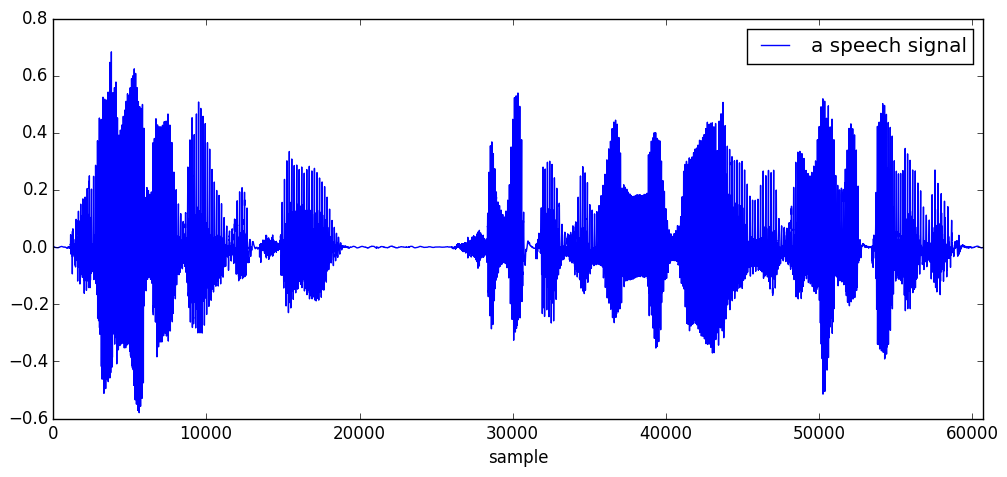

PyObject <matplotlib.legend.Legend object at 0x7f1ac87811d0>

In [3]:
# Reading a speech signal
filepath = joinpath(Pkg.dir("WORLD"), "test", "data", "test16k.wav")
x, fs = wavread(filepath)
x = vec(x) # monoral
fs = convert(Int, fs)

# Visualize the speech signal in time-domain
plot(1:endof(x), x, label="a speech signal")
xlim(1, endof(x))
xlabel("sample")
legend()

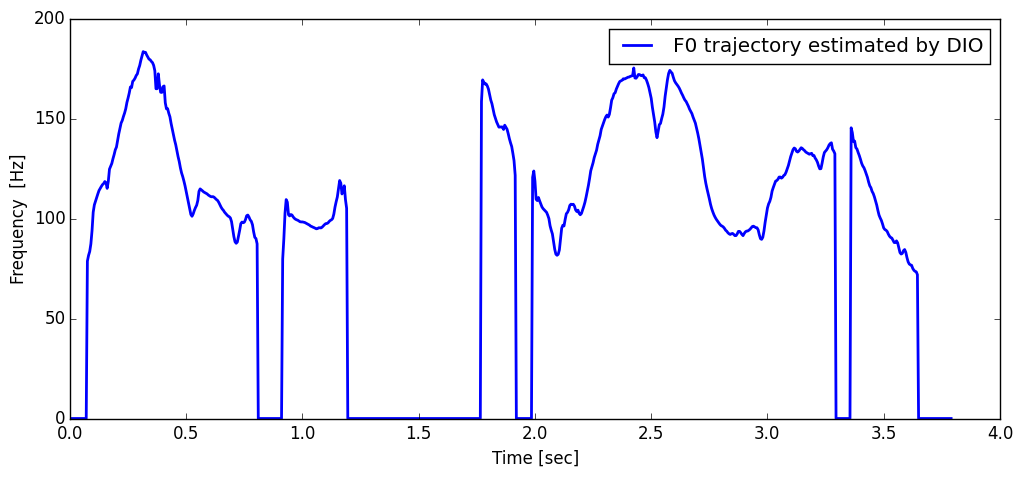

PyObject <matplotlib.legend.Legend object at 0x7f1aa45eda10>

In [4]:
# Fundamental frequency (f0) estimation by DIO
period = 5.0
opt = DioOption(f0floor=71.0, f0ceil=800.0, channels_in_octave=2.0, period=period, speed=1)
f0, timeaxis = dio(x, fs, opt)

plot(timeaxis, f0, label="F0 trajectory estimated by DIO", linewidth="2")
xlabel("Time [sec]")
ylabel("Frequency  [Hz]")
legend()

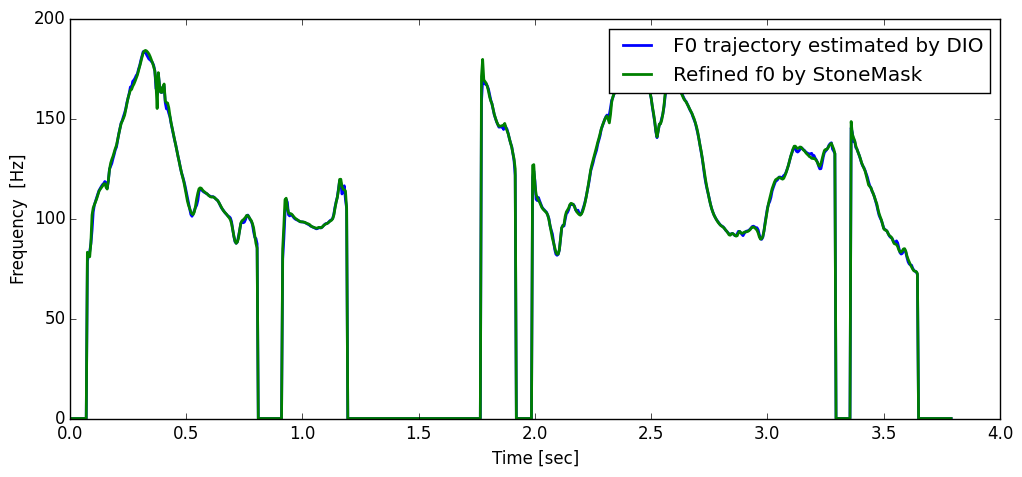

PyObject <matplotlib.legend.Legend object at 0x7f1aa1f52690>

In [5]:
f0_by_dio = copy(f0)

# F0 refinement by StoneMask
f0 = stonemask(x, fs, timeaxis, f0_by_dio)

plot(timeaxis, f0_by_dio, label="F0 trajectory estimated by DIO", linewidth="2")
plot(timeaxis, f0, label="Refined f0 by StoneMask", linewidth="2")
xlabel("Time [sec]")
ylabel("Frequency  [Hz]")
legend()

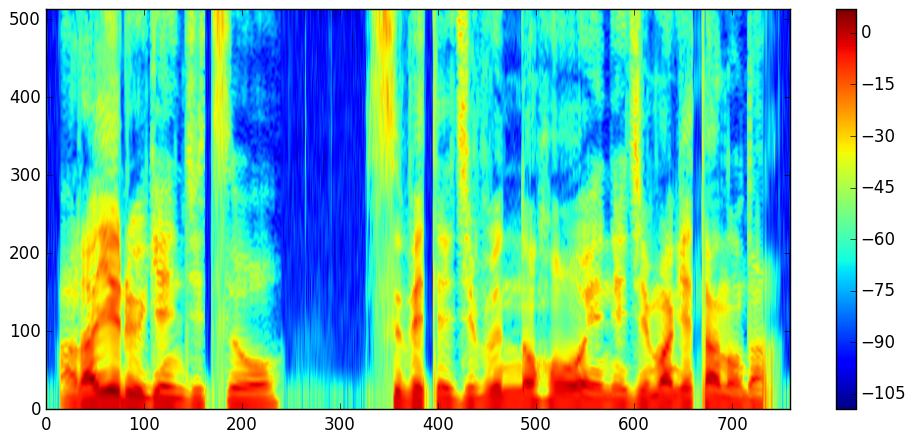

PyObject <matplotlib.colorbar.Colorbar instance at 0x7f1aa1f726c8>

In [6]:
# Spectral envelope estimatino by CheapTrick
spectrogram = cheaptrick(x, fs, timeaxis, f0)

imshow(10log10(spectrogram), origin="lower", aspect="auto")
colorbar()

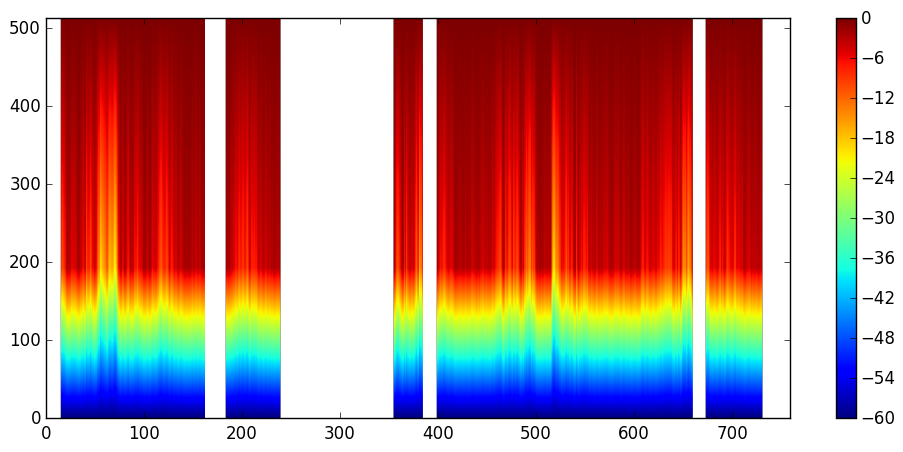

PyObject <matplotlib.colorbar.Colorbar instance at 0x7f1aa1c781b8>

In [7]:
# Aperiodicity ratio estimation
aperiodicity = d4c(x, fs, timeaxis, f0)

imshow(20log10(aperiodicity), origin="lower", aspect="auto")
colorbar()

Mean error: 0.13664598604120687


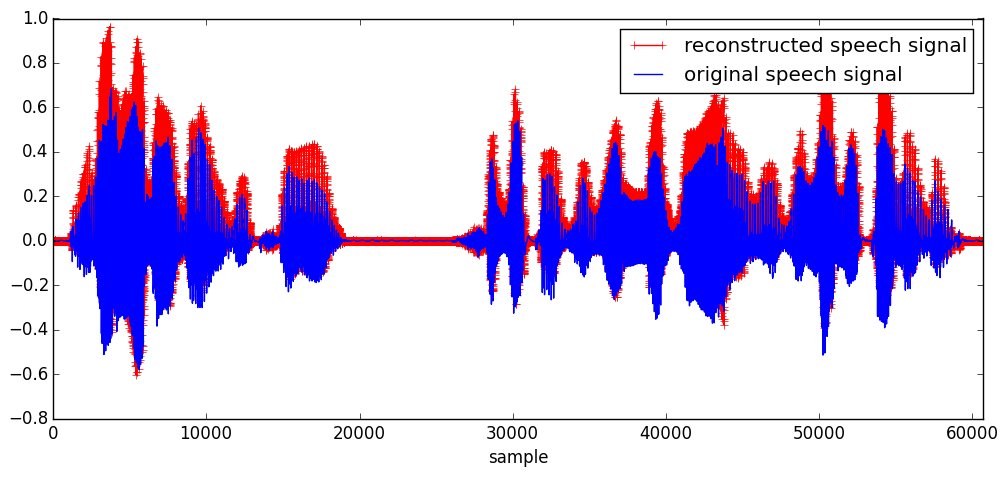

PyObject <matplotlib.legend.Legend object at 0x7f1aa1b78e90>

In [8]:
# Sysnthesis from f0, spectral envelope and aperiodicity
y = synthesis(f0, spectrogram, aperiodicity, period, fs, length(x))

println("Mean error: ", mean(abs(y-x))/maxabs(x))

plot(1:endof(y), y, "r-+", label="reconstructed speech signal")
plot(1:endof(x), x, label="original speech signal")
xlim(1, endof(y))
xlabel("sample")
legend()

## Compact speech parameterization

Raw spectrum envelop and aperiodicity spectrum are relatively high dimentional (offen more than 513 or 1023) so one might want to get more compact representation. To do so, mel-cepstrum could be a good choice. As far as I know, this would be useful in statistical speech synthesis and statistical voice conversion. 

### Conversion between spectrum envelope and mel-cepstrum

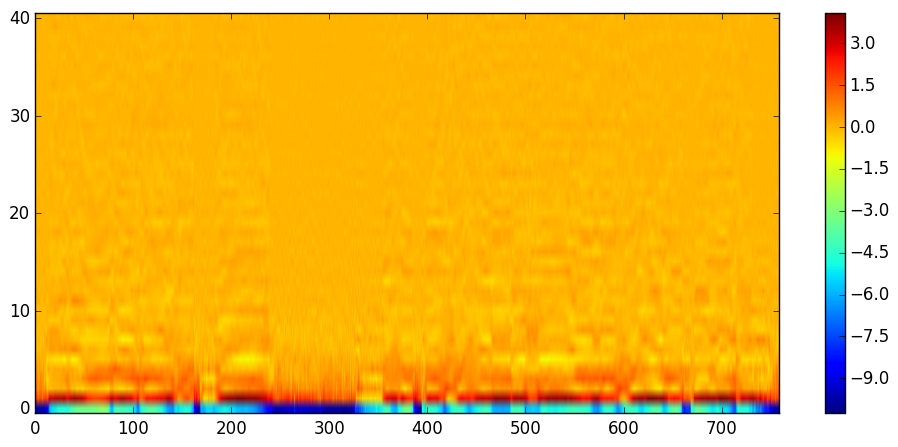

PyObject <matplotlib.colorbar.Colorbar instance at 0x7f1aa1ab34d0>

In [9]:
α = 0.41
fftlen = get_fftsize_for_cheaptrick(fs)
order = 40

# Feature dimention reduces to 41 from 513!
mc = sp2mc(spectrogram, order, α)

imshow(mc, origin="lower", aspect="auto")
colorbar()

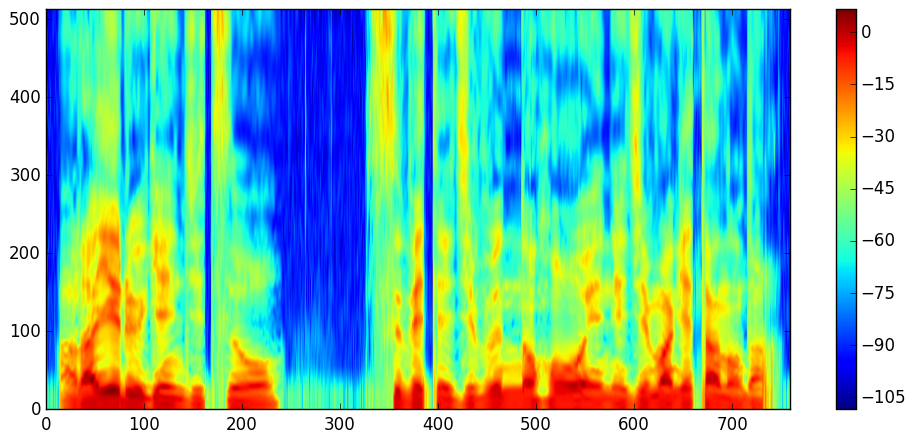

PyObject <matplotlib.colorbar.Colorbar instance at 0x7f1ac87c6ea8>

In [10]:
approximate_spectrogram = mc2sp(mc, α, fftlen)

imshow(10log10(approximate_spectrogram), origin="lower", aspect="auto")
colorbar()

### Convertion between aperiodicity spectrum and aperiodicity mel-cesptrum

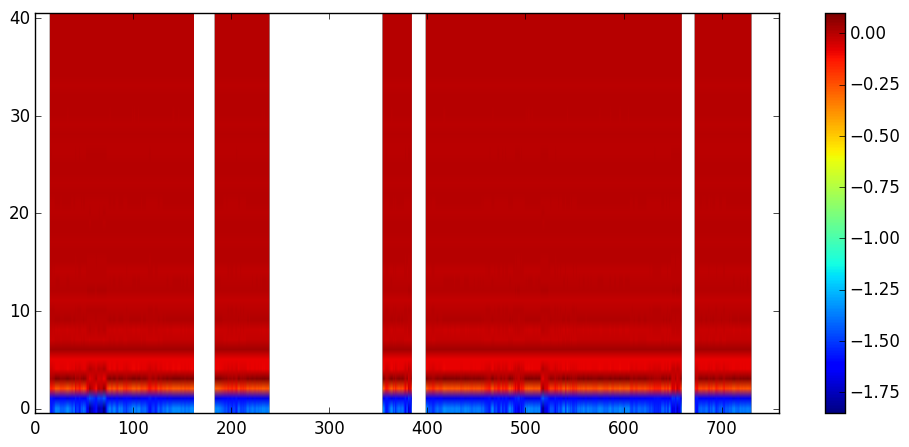

PyObject <matplotlib.colorbar.Colorbar instance at 0x7f1aa09da440>

In [13]:
α = 0.41
fftlen = get_fftsize_for_cheaptrick(fs)
order = 40

mc_ap = sp2mc(aperiodicity, order, α)

imshow(mc_ap, origin="lower", aspect="auto")
colorbar()

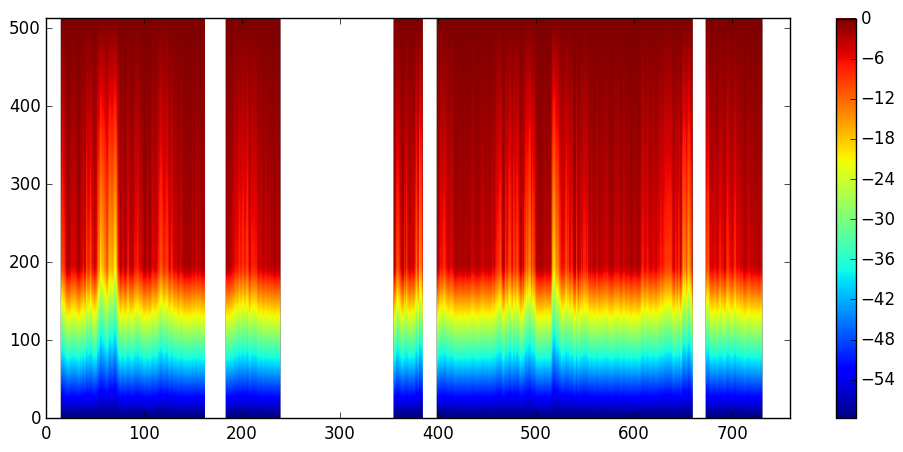

PyObject <matplotlib.colorbar.Colorbar instance at 0x7f1aa08a8710>

In [14]:
approximate_aperiodicity = mc2sp(mc_ap, α, fftlen)

imshow(20log10(approximate_aperiodicity), origin="lower", aspect="auto")
colorbar()